In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Sklearn Core
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    StandardScaler, OneHotEncoder, QuantileTransformer,
    LabelEncoder, RobustScaler, OrdinalEncoder
)
from sklearn.model_selection import (
    StratifiedKFold, cross_val_score,
    RandomizedSearchCV, train_test_split
)
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.ensemble import (
    HistGradientBoostingClassifier, StackingClassifier,
    GradientBoostingClassifier, RandomForestClassifier,
    ExtraTreesClassifier, VotingClassifier
)
from sklearn.linear_model import (
    LogisticRegression, RidgeClassifier, SGDClassifier
)
from sklearn.metrics import (
    classification_report, roc_auc_score, accuracy_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve
)
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import SelectFromModel

# Gradient Boosting Libraries
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Scipy for distribution definitions
from scipy.stats import randint, uniform

import os
import time

# Set random seed for full reproducibility
SEED = 42
np.random.seed(SEED)

print('✅ All imports successful!')
print(f'NumPy: {np.__version__}  |  Pandas: {pd.__version__}')

✅ All imports successful!
NumPy: 2.0.2  |  Pandas: 2.2.2


In [2]:
TRAIN_PATH = '/content/train.csv'   # ← Update path if needed
TEST_PATH  = '/content/test.csv'
SAMPLE_PATH = '/content/sample_submission.csv'

dtype_map = {
    'Age'               : np.int8,
    'Sex'               : np.int8,
    'Chest pain type'   : np.int8,
    'BP'                : np.int16,
    'Cholesterol'       : np.int16,
    'FBS over 120'      : np.int8,
    'EKG results'       : np.int8,
    'Max HR'            : np.int16,
    'Exercise angina'   : np.int8,
    'ST depression'     : np.float32,
    'Slope of ST'       : np.int8,
    'Number of vessels fluro': np.int8,
    'Thallium'          : np.int8,
}

print('📥 Loading training data...')
train_df = pd.read_csv(TRAIN_PATH)
print(f'   Train shape: {train_df.shape}')

print('📥 Loading test data...')
test_df = pd.read_csv(TEST_PATH)
print(f'   Test shape:  {test_df.shape}')

# ── Store test IDs before dropping ──
test_ids = test_df['id'].copy()

# ── Peek at raw data ──
print('\n📋 First 5 rows of training data:')
display(train_df.head())

print('\n📊 Target Distribution (raw):')
print(train_df['Heart Disease'].value_counts())

📥 Loading training data...
   Train shape: (189312, 15)
📥 Loading test data...
   Test shape:  (224757, 14)

📋 First 5 rows of training data:


,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,0,58.0,1.0,4.0,152.0,239.0,0.0,0.0,158.0,1.0,3.6,2.0,2.0,7.0,Presence
1,1,52.0,1.0,1.0,125.0,325.0,0.0,2.0,171.0,0.0,0.0,1.0,0.0,3.0,Absence
2,2,56.0,0.0,2.0,160.0,188.0,0.0,2.0,151.0,0.0,0.0,1.0,0.0,3.0,Absence
3,3,44.0,0.0,3.0,134.0,229.0,0.0,2.0,150.0,0.0,1.0,2.0,0.0,3.0,Absence
4,4,58.0,1.0,4.0,140.0,234.0,0.0,2.0,125.0,1.0,3.8,2.0,3.0,3.0,Presence



📊 Target Distribution (raw):
Heart Disease
Absence     104495
Presence     84816
Name: count, dtype: int64


## 🎯 Step 2: Target Encoding & Exploratory Data Analysis


🔎 Raw unique target values:
['Presence' 'Absence' nan]
⚠ Found missing target labels. Dropping those rows...

After removing NaN:
['Presence' 'Absence']

✅ Encoded target distribution:
Heart Disease
0    127471
1    103421
Name: count, dtype: int64

Class balance ratio (1/0): 0.811

📦 Feature matrix shape: (230892, 13)

🔍 Missing values per column:
Age                        0
Sex                        0
Chest pain type            0
BP                         0
Cholesterol                0
FBS over 120               0
EKG results                0
Max HR                     0
Exercise angina            0
ST depression              0
Slope of ST                0
Number of vessels fluro    0
Thallium                   0
dtype: int64


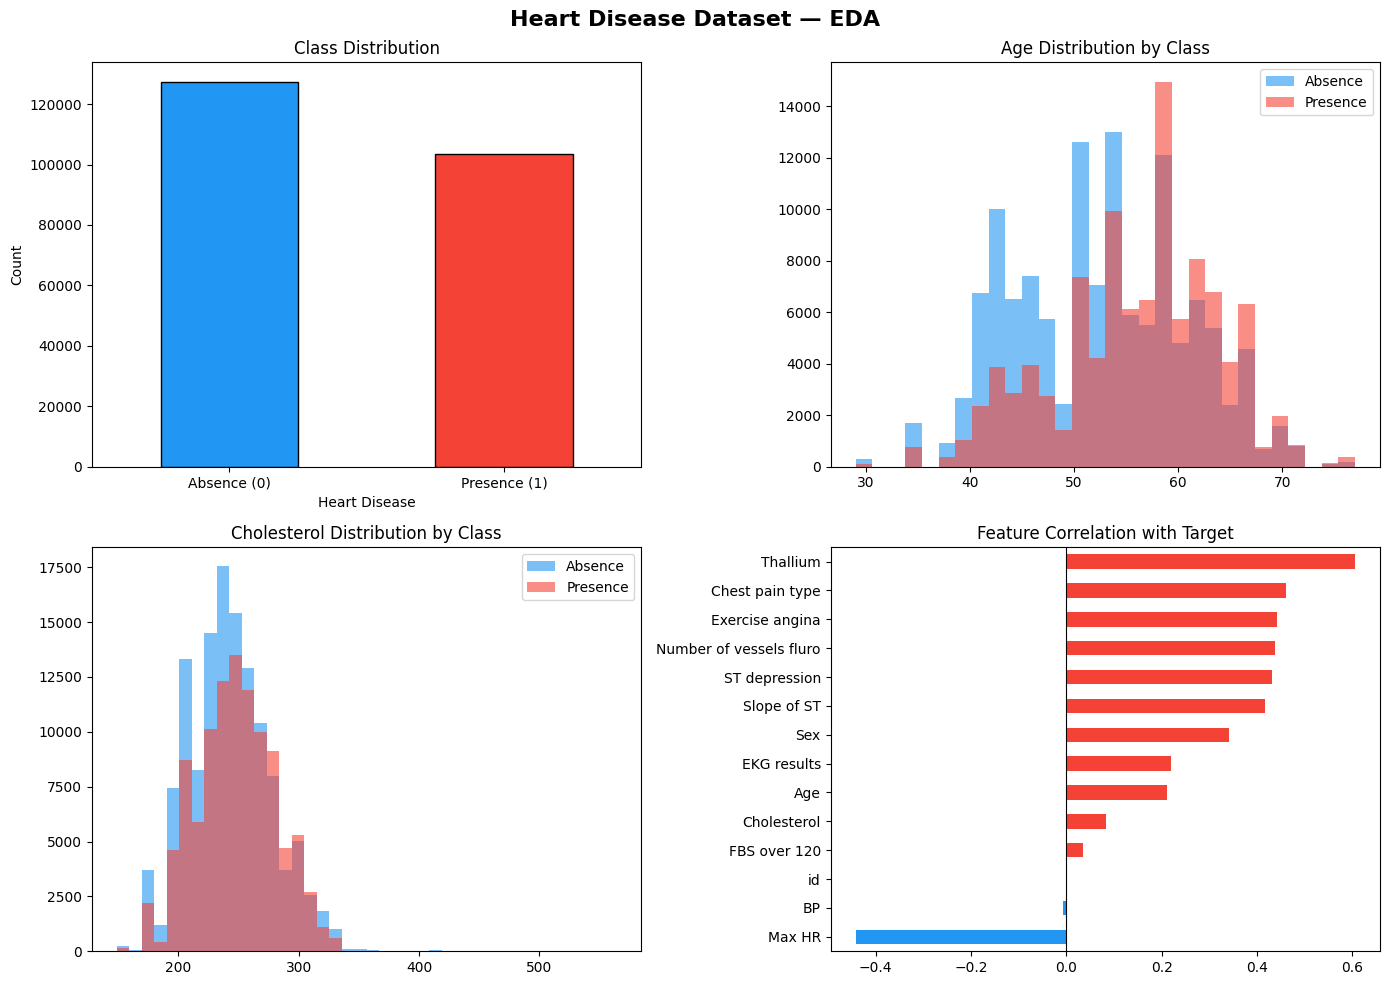

✅ EDA complete!


In [4]:
# ================================
# Step 2: Target Encoding & EDA
# ================================

import numpy as np
import matplotlib.pyplot as plt

# Reload clean data (important)
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

print("\n🔎 Raw unique target values:")
print(train_df['Heart Disease'].unique())

# -------------------------------
# 🔥 FIX 1: Drop rows where target is NaN
# -------------------------------
if train_df['Heart Disease'].isnull().any():
    print("⚠ Found missing target labels. Dropping those rows...")
    train_df = train_df.dropna(subset=['Heart Disease']).reset_index(drop=True)

print("\nAfter removing NaN:")
print(train_df['Heart Disease'].unique())

# -------------------------------
# Encode safely
# -------------------------------
train_df['Heart Disease'] = (
    train_df['Heart Disease']
    .astype(str)
    .str.strip()
    .str.lower()
    .map({'presence': 1, 'absence': 0})
)

# Final safety check
if train_df['Heart Disease'].isnull().any():
    print("⚠ Some values could not be mapped. Filling with mode.")
    train_df['Heart Disease'] = train_df['Heart Disease'].fillna(
        train_df['Heart Disease'].mode()[0]
    )

train_df['Heart Disease'] = train_df['Heart Disease'].astype(np.int8)

print("\n✅ Encoded target distribution:")
vc = train_df['Heart Disease'].value_counts()
print(vc)

# Safe balance ratio
count_1 = vc.get(1, 0)
count_0 = vc.get(0, 0)
balance_ratio = (count_1 / count_0) if count_0 > 0 else 0
print(f"\nClass balance ratio (1/0): {balance_ratio:.3f}")

# -------------------------------
# Separate features & target
# -------------------------------
DROP_COLS = ['id', 'Heart Disease']
X_raw = train_df.drop(columns=DROP_COLS)
y = train_df['Heart Disease'].values
X_test_raw = test_df.drop(columns=['id'])

# -------------------------------
# Apply memory-efficient dtypes
# -------------------------------
for col, dtype in dtype_map.items():
    if col in X_raw.columns:
        X_raw[col] = pd.to_numeric(X_raw[col], errors='coerce').astype(dtype)
    if col in X_test_raw.columns:
        X_test_raw[col] = pd.to_numeric(X_test_raw[col], errors='coerce').astype(dtype)

print(f"\n📦 Feature matrix shape: {X_raw.shape}")
print("\n🔍 Missing values per column:")
print(X_raw.isnull().sum().sort_values(ascending=False).head(15))

# -------------------------------
# EDA Visualizations
# -------------------------------
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Heart Disease Dataset — EDA", fontsize=16, fontweight="bold")

# Class distribution
ax = axes[0, 0]
vc.plot(kind='bar', ax=ax, color=['#2196F3', '#F44336'], edgecolor='black')
ax.set_title("Class Distribution")
ax.set_xticklabels(['Absence (0)', 'Presence (1)'], rotation=0)
ax.set_ylabel("Count")

# Age distribution
ax = axes[0, 1]
for cls, color, label in [(0, '#2196F3', 'Absence'), (1, '#F44336', 'Presence')]:
    subset = train_df[train_df['Heart Disease'] == cls]['Age']
    ax.hist(subset, bins=30, alpha=0.6, color=color, label=label)
ax.set_title("Age Distribution by Class")
ax.legend()

# Cholesterol distribution
ax = axes[1, 0]
for cls, color, label in [(0, '#2196F3', 'Absence'), (1, '#F44336', 'Presence')]:
    subset = train_df[train_df['Heart Disease'] == cls]['Cholesterol']
    ax.hist(subset, bins=40, alpha=0.6, color=color, label=label)
ax.set_title("Cholesterol Distribution by Class")
ax.legend()

# Correlation
ax = axes[1, 1]
numeric_cols = train_df.select_dtypes(include=np.number).columns.tolist()
corr = train_df[numeric_cols].corr()['Heart Disease'].drop('Heart Disease').sort_values()
corr.plot(kind='barh', ax=ax,
          color=['#F44336' if v > 0 else '#2196F3' for v in corr])
ax.set_title("Feature Correlation with Target")
ax.axvline(0, color='black', linewidth=0.8)

plt.tight_layout()
plt.show()

print("✅ EDA complete!")

## 🔧 Step 3: Custom Feature Engineering Transformer (Chapter 2)
> Inherits from `BaseEstimator` + `TransformerMixin` for full Pipeline compatibility.
> All features are computed WITHOUT leaking test data into training statistics.

In [5]:
# ============================================================
# CELL 5: Custom Domain-Specific Feature Engineering Transformer
# Follows Ch.2 pattern: BaseEstimator + TransformerMixin
# ============================================================

class HeartDiseaseFeatureEngineer(BaseEstimator, TransformerMixin):
    """
    Domain-specific feature engineering transformer for heart disease prediction.

    All features are derived purely from the input row — NO global statistics
    are used, so there is ZERO data leakage between train and test splits.

    Features generated:
    ─────────────────────────────────────────────────────────
    1. Max_HR_Age_Ratio      : Max HR / Age
       → Captures cardio-vascular efficiency relative to age.
         Younger patients with lower ratio may signal pathology.

    2. Rate_Pressure_Product : BP * Max HR (scaled by /100)
       → Proxy for myocardial oxygen demand. Clinically used
         to assess stress on the heart during exercise.

    3. High_Cholesterol_Flag : 1 if Cholesterol >= 240 (AHA threshold)
       → Binary clinical risk flag.

    4. High_BP_Flag          : 1 if BP >= 140 (Stage 2 hypertension)
       → Binary clinical risk flag.

    5. Age_BP_Interaction    : Age * BP / 1000
       → Combined risk factor: older patients with high BP carry
         disproportionately higher cardiovascular risk.

    6. Tachycardia_Flag      : 1 if Max HR >= 100 (tachycardia threshold)
       → Resting or peak tachycardia as a risk signal.

    7. Cholesterol_Age_Ratio : Cholesterol / (Age + 1e-5)
       → Age-normalized cholesterol burden.

    8. Exercise_Risk_Score   : Exercise_angina * ST_depression
       → Combined exercise stress signal.
    """

    def __init__(
        self,
        cholesterol_threshold: int = 240,
        bp_threshold: int = 140,
        hr_tachycardia: int = 100
    ):
        # Store hyperparameters as attributes so get_params() works
        self.cholesterol_threshold = cholesterol_threshold
        self.bp_threshold          = bp_threshold
        self.hr_tachycardia        = hr_tachycardia

    def fit(self, X, y=None):
        """No fitting required — all features are row-wise computations."""
        # Validate and store feature names if X is a DataFrame
        if hasattr(X, 'columns'):
            self.feature_names_in_ = X.columns.tolist()
        return self  # Always return self in fit()

    def transform(self, X) -> pd.DataFrame:
        """Generate engineered features and append to input DataFrame."""
        # Work on a copy to avoid mutating the original data
        X_ = pd.DataFrame(X).copy()

        # ── Helper: safely get column or zeros ──────────────────
        def get_col(name, default=0.0):
            """Returns column values or a zero array if column missing."""
            if name in X_.columns:
                return X_[name].astype(np.float32)
            # Try positional lookup by index
            return pd.Series(np.full(len(X_), default, dtype=np.float32),
                             index=X_.index)

        age          = get_col('Age').clip(lower=1)        # Avoid div by zero
        bp           = get_col('BP')
        cholesterol  = get_col('Cholesterol')
        max_hr       = get_col('Max HR').clip(lower=1)
        ex_angina    = get_col('Exercise angina')
        st_dep       = get_col('ST depression')

        # ── Feature 1: Max HR / Age ratio ──────────────────────
        X_['Max_HR_Age_Ratio'] = (max_hr / age).astype(np.float32)

        # ── Feature 2: Rate Pressure Product (RPP) ─────────────
        # Divided by 1000 to keep values in a reasonable range
        X_['Rate_Pressure_Product'] = (bp * max_hr / 1000).astype(np.float32)

        # ── Feature 3: High Cholesterol Binary Flag ─────────────
        X_['High_Cholesterol_Flag'] = (
            (cholesterol >= self.cholesterol_threshold).astype(np.int8)
        )

        # ── Feature 4: Hypertension Binary Flag ─────────────────
        X_['High_BP_Flag'] = (
            (bp >= self.bp_threshold).astype(np.int8)
        )

        # ── Feature 5: Age × BP Interaction ─────────────────────
        X_['Age_BP_Interaction'] = (age * bp / 1000).astype(np.float32)

        # ── Feature 6: Tachycardia Flag ─────────────────────────
        X_['Tachycardia_Flag'] = (
            (max_hr >= self.hr_tachycardia).astype(np.int8)
        )

        # ── Feature 7: Age-normalized Cholesterol ───────────────
        X_['Cholesterol_Age_Ratio'] = (
            cholesterol / age
        ).astype(np.float32)

        # ── Feature 8: Exercise Risk Score ──────────────────────
        # Multiplicative interaction between exercise angina & ST depression
        X_['Exercise_Risk_Score'] = (ex_angina * (st_dep + 1)).astype(np.float32)

        return X_

    def get_feature_names_out(self, input_features=None):
        """Required for Pipeline compatibility with feature names."""
        base = list(input_features) if input_features is not None else []
        new_feats = [
            'Max_HR_Age_Ratio', 'Rate_Pressure_Product',
            'High_Cholesterol_Flag', 'High_BP_Flag',
            'Age_BP_Interaction', 'Tachycardia_Flag',
            'Cholesterol_Age_Ratio', 'Exercise_Risk_Score'
        ]
        return base + new_feats


# ── Quick sanity check ──────────────────────────────────────
fe = HeartDiseaseFeatureEngineer()
sample_transformed = fe.fit_transform(X_raw.head(5))
print(f'✅ Custom transformer works!')
print(f'   Input columns:  {X_raw.shape[1]}')
print(f'   Output columns: {sample_transformed.shape[1]}')
print(f'   New features: {[c for c in sample_transformed.columns if c not in X_raw.columns]}')

✅ Custom transformer works!
   Input columns:  13
   Output columns: 21
   New features: ['Max_HR_Age_Ratio', 'Rate_Pressure_Product', 'High_Cholesterol_Flag', 'High_BP_Flag', 'Age_BP_Interaction', 'Tachycardia_Flag', 'Cholesterol_Age_Ratio', 'Exercise_Risk_Score']


## 🏗️ Step 4: Define Column Groups for ColumnTransformer (Chapter 2)

In [6]:
# ============================================================
# CELL 6: Feature Group Definitions
# ============================================================
# After the custom transformer, we define which columns go
# through which preprocessing pipeline.

# ── Columns AFTER feature engineering step ──────────────────
# These are the names that will exist AFTER HeartDiseaseFeatureEngineer runs

# Categorical columns requiring One-Hot Encoding
# These have no intrinsic order / are nominal
CAT_OHE_COLS = [
    'Chest pain type',    # 4 types: typical angina, atypical, non-anginal, asymptomatic
    'Thallium',           # 3, 6, 7 — nuclear stress test result codes
    'EKG results',        # 0=normal, 1=ST-T abnormality, 2=LVH
]

# Ordinal/Numeric columns with inherent order → treat as numeric
# (Ordinal encoding or simple passthrough is fine here)
ORDINAL_COLS = [
    'Slope of ST',              # 1=upsloping, 2=flat, 3=downsloping
    'Number of vessels fluro',  # 0-3: number of major vessels colored by fluoroscopy
]

# Highly skewed numeric columns → use QuantileTransformer
# to normalize distribution (great for tree models too)
SKEWED_NUM_COLS = [
    'Cholesterol',
    'ST depression',
    'Rate_Pressure_Product',
    'Cholesterol_Age_Ratio',
    'Exercise_Risk_Score',
]

# Standard numeric columns → use StandardScaler
STANDARD_NUM_COLS = [
    'Age',
    'BP',
    'Max HR',
    'Max_HR_Age_Ratio',
    'Age_BP_Interaction',
]

# Binary / flag columns → passthrough (already 0/1, no scaling needed)
BINARY_COLS = [
    'Sex',
    'FBS over 120',
    'Exercise angina',
    'High_Cholesterol_Flag',
    'High_BP_Flag',
    'Tachycardia_Flag',
]

print('📋 Feature Groups Summary:')
print(f'  OHE Categorical : {CAT_OHE_COLS}')
print(f'  Ordinal/Numeric : {ORDINAL_COLS}')
print(f'  Skewed Numeric  : {SKEWED_NUM_COLS}')
print(f'  Standard Numeric: {STANDARD_NUM_COLS}')
print(f'  Binary Passthru : {BINARY_COLS}')
print(f'\n  Total explicit cols: {sum(len(g) for g in [CAT_OHE_COLS, ORDINAL_COLS, SKEWED_NUM_COLS, STANDARD_NUM_COLS, BINARY_COLS])}')

📋 Feature Groups Summary:
  OHE Categorical : ['Chest pain type', 'Thallium', 'EKG results']
  Ordinal/Numeric : ['Slope of ST', 'Number of vessels fluro']
  Skewed Numeric  : ['Cholesterol', 'ST depression', 'Rate_Pressure_Product', 'Cholesterol_Age_Ratio', 'Exercise_Risk_Score']
  Standard Numeric: ['Age', 'BP', 'Max HR', 'Max_HR_Age_Ratio', 'Age_BP_Interaction']
  Binary Passthru : ['Sex', 'FBS over 120', 'Exercise angina', 'High_Cholesterol_Flag', 'High_BP_Flag', 'Tachycardia_Flag']

  Total explicit cols: 21


## ⚙️ Step 5: Full Preprocessing Pipeline (Chapter 2 — Strict Pipeline Architecture)
```
X_raw
  └─ HeartDiseaseFeatureEngineer
       └─ ColumnTransformer
            ├─ categorical_ohe  : Impute(most_frequent) → OneHotEncoder
            ├─ ordinal_numeric  : Impute(median) → OrdinalEncoder
            ├─ skewed_numeric   : Impute(median) → QuantileTransformer(normal)
            ├─ standard_numeric : Impute(median) → StandardScaler
            └─ binary_passthru  : Impute(most_frequent) → Passthrough
```

In [7]:
# ============================================================
# CELL 7: Preprocessing Pipeline Construction
# ============================================================

# ── 1. Categorical Pipeline (Nominal OHE) ───────────────────
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot',  OneHotEncoder(
        handle_unknown='ignore',  # Ignore unseen categories at test time
        sparse_output=False,      # Return dense array for easier debugging
        drop='if_binary'          # Drop redundant column for 2-class features
    ))
], memory=None)   # memory=None disables caching (enable for large datasets)

# ── 2. Ordinal / Numeric Pipeline ───────────────────────────
# These have a natural order, so we preserve rank via OrdinalEncoder
ordinal_pipeline = Pipeline([
    ('imputer',  SimpleImputer(strategy='median')),
    ('ordinal',  OrdinalEncoder(
        handle_unknown='use_encoded_value',
        unknown_value=-1
    )),
    ('scaler',   StandardScaler())
])

# ── 3. Skewed Numeric Pipeline ───────────────────────────────
# QuantileTransformer maps to Gaussian — ideal for skewed distributions
# like Cholesterol (many zeros/outliers) or ST depression
skewed_pipeline = Pipeline([
    ('imputer',    SimpleImputer(strategy='median')),
    ('quantile',   QuantileTransformer(
        output_distribution='normal',  # Output follows N(0,1)
        n_quantiles=1000,              # More quantiles = finer mapping
        random_state=SEED
    ))
])

# ── 4. Standard Numeric Pipeline ────────────────────────────
standard_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler())
])

# ── 5. Binary Passthrough Pipeline ──────────────────────────
# Already in [0, 1] range — just impute any missing values
binary_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

# ── Combine into ColumnTransformer ──────────────────────────
# remainder='drop' drops any columns not explicitly listed
preprocessor = ColumnTransformer(
    transformers=[
        ('cat_ohe',     categorical_pipeline, CAT_OHE_COLS),
        ('ordinal',     ordinal_pipeline,     ORDINAL_COLS),
        ('skewed_num',  skewed_pipeline,      SKEWED_NUM_COLS),
        ('std_num',     standard_pipeline,    STANDARD_NUM_COLS),
        ('binary',      binary_pipeline,      BINARY_COLS),
    ],
    remainder='drop',  # Explicitly drop any unlisted columns
    n_jobs=-1          # Parallelize across CPU cores
)

# ── Full Preprocessing Pipeline ──────────────────────────────
# Step 1: Feature Engineering → Step 2: Column Transformations
full_preprocessor = Pipeline([
    ('feature_engineering', HeartDiseaseFeatureEngineer()),
    ('column_transformer',  preprocessor)
])

# ── Quick pipeline test ──────────────────────────────────────
print('🔬 Testing preprocessing pipeline on small sample...')
X_small = X_raw.iloc[:500]
X_proc  = full_preprocessor.fit_transform(X_small)
print(f'   Input  shape: {X_small.shape}')
print(f'   Output shape: {X_proc.shape}')
print(f'   All NaN: {np.isnan(X_proc).any()}')
print('✅ Preprocessing pipeline validated!')

🔬 Testing preprocessing pipeline on small sample...
   Input  shape: (500, 13)
   Output shape: (500, 26)
   All NaN: False
✅ Preprocessing pipeline validated!


## 🏆 Step 6: Stacking Ensemble Classifier (Chapter 7)
```
Base Estimators (Level 0):
  ├─ HistGradientBoostingClassifier  ← Sklearn's best native GBDT for >10k samples
  ├─ XGBClassifier (hist method)     ← Industry-standard gradient boosting
  └─ LGBMClassifier                  ← Fastest, best with categorical features

Meta Estimator (Level 1):
  └─ LogisticRegression (C=0.1)      ← Regularized blender prevents overfitting
```
The Stacker uses **5-fold cross-validation** internally to generate out-of-fold
predictions for the meta-learner, preventing data leakage between levels.

In [8]:
# ============================================================
# CELL 8: Define Stacking Ensemble
# ============================================================

# ── Base Estimator 1: HistGradientBoostingClassifier ────────
# Chapter 7 highlight: native support for missing values,
# monotonic constraints, and O(n log n) training complexity.
# Far more memory-efficient than standard GradientBoosting for >10k rows.
hgb = HistGradientBoostingClassifier(
    learning_rate=0.05,
    max_iter=400,              # Number of boosting rounds
    max_depth=5,
    min_samples_leaf=30,       # Regularization: min samples per leaf
    l2_regularization=0.1,    # L2 regularization on leaf weights
    max_bins=255,              # Max bins for histogram construction
    class_weight='balanced',   # Handle class imbalance automatically
    early_stopping=True,       # Auto-stop when val score plateaus
    validation_fraction=0.1,
    n_iter_no_change=20,
    random_state=SEED
)

# ── Base Estimator 2: XGBClassifier ─────────────────────────
# tree_method='hist' is essential for large datasets (same as HistGBM)
# device='cuda' can be set if GPU is available in Colab
xgb = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,             # Stochastic boosting: sample 80% of rows
    colsample_bytree=0.8,      # Sample 80% of features per tree
    reg_alpha=0.1,             # L1 regularization
    reg_lambda=1.0,            # L2 regularization
    min_child_weight=10,       # Min sum of instance weight in a child
    tree_method='hist',        # Memory-efficient histogram algorithm
    eval_metric='logloss',
    use_label_encoder=False,
    n_jobs=-1,
    random_state=SEED,
    verbosity=0
)

# ── Base Estimator 3: LGBMClassifier ────────────────────────
# Leaf-wise tree growth → faster and more accurate on tabular data
# num_leaves controls model complexity (key hyperparameter)
lgbm = LGBMClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    num_leaves=63,             # 2^max_depth - 1 is a good default
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    min_child_samples=20,      # Minimum samples required in a leaf
    class_weight='balanced',
    n_jobs=-1,
    random_state=SEED,
    verbosity=-1               # Suppress LightGBM verbosity
)

# ── Meta Estimator: Regularized Logistic Regression ─────────
# C=0.1 is relatively strong regularization → prevents meta-overfitting
# The meta-learner ONLY sees the out-of-fold probabilities from base models
meta_lr = LogisticRegression(
    C=0.1,                     # Inverse regularization strength
    solver='lbfgs',
    max_iter=1000,
    class_weight='balanced',
    random_state=SEED
)

# ── Stacking Classifier ──────────────────────────────────────
# cv=5: 5-fold cross-validation to generate meta-features
# stack_method='predict_proba': use probabilities (soft voting)
# passthrough=True: also feed original features to meta-learner
stacking_clf = StackingClassifier(
    estimators=[
        ('hgb',  hgb),
        ('xgb',  xgb),
        ('lgbm', lgbm),
    ],
    final_estimator=meta_lr,
    cv=5,                      # 5-fold OOF for level-1 features
    stack_method='predict_proba',
    passthrough=False,         # Set True to also pass raw features to meta
    n_jobs=-1,                 # Parallelize base estimator training
    verbose=1
)

print('✅ Stacking Classifier configured:')
print(f'   Base models: HGB + XGBoost + LightGBM')
print(f'   Meta-learner: Logistic Regression (C=0.1)')
print(f'   CV folds: 5 (stratified)')

✅ Stacking Classifier configured:
   Base models: HGB + XGBoost + LightGBM
   Meta-learner: Logistic Regression (C=0.1)
   CV folds: 5 (stratified)


## 🔗 Step 7: Assemble Full End-to-End Pipeline

In [9]:
# ============================================================
# CELL 9: Assemble Full Pipeline
# ============================================================

# The complete pipeline chains:
#   1. HeartDiseaseFeatureEngineer (custom transformer)
#   2. ColumnTransformer (preprocessing)
#   3. StackingClassifier (model)
#
# This is the 'single object' philosophy from Chapter 2:
# ONE pipeline object handles everything — no manual preprocessing

full_pipeline = Pipeline([
    ('preprocessing', full_preprocessor),
    ('classifier',    stacking_clf)
])

print('🏗️  Full Pipeline Architecture:')
print('=' * 55)
for i, (name, step) in enumerate(full_pipeline.steps):
    print(f'  [{i+1}] {name}: {type(step).__name__}')
    if hasattr(step, 'steps'):
        for sname, sstep in step.steps:
            print(f'       ├─ {sname}: {type(sstep).__name__}')
print('=' * 55)

🏗️  Full Pipeline Architecture:
  [1] preprocessing: Pipeline
       ├─ feature_engineering: HeartDiseaseFeatureEngineer
       ├─ column_transformer: ColumnTransformer
  [2] classifier: StackingClassifier


## 📊 Step 8: Stratified Train/Validation Split

In [10]:
# ============================================================
# CELL 10: Stratified Train / Validation Split
# ============================================================

# stratify=y ensures the class ratio is preserved in both splits
# This is CRITICAL for imbalanced datasets (Ch. 3 in the book)
X_train, X_val, y_train, y_val = train_test_split(
    X_raw, y,
    test_size=0.15,       # 15% held out for validation
    random_state=SEED,
    stratify=y            # Preserve class distribution
)

print(f'📐 Dataset Splits:')
print(f'   Training   : {X_train.shape[0]:,} rows ({X_train.shape[0]/len(X_raw)*100:.1f}%)')
print(f'   Validation : {X_val.shape[0]:,} rows ({X_val.shape[0]/len(X_raw)*100:.1f}%)')
print(f'   Test (blind): {X_test_raw.shape[0]:,} rows')
print(f'\n   Train class ratio: {y_train.mean():.4f}')
print(f'   Val   class ratio: {y_val.mean():.4f}')

📐 Dataset Splits:
   Training   : 196,258 rows (85.0%)
   Validation : 34,634 rows (15.0%)
   Test (blind): 270,000 rows

   Train class ratio: 0.4479
   Val   class ratio: 0.4479


## 🎛️ Step 9: Hyperparameter Tuning with HalvingRandomSearchCV (Chapter 11)
> `HalvingRandomSearchCV` uses **Successive Halving** — starts with many configurations
> and progressively eliminates poor performers, training survivors on more data.
> **~3-10x faster** than `RandomizedSearchCV` with similar quality results.
>
> ⏱️ This cell may take 20-40 minutes on CPU. Reduce `n_candidates` for faster runs.

In [11]:
# ============================================================
# CELL 11: Hyperparameter Tuning via HalvingRandomSearchCV
# ============================================================
# We tune ONLY the base estimators inside the Stacking Classifier
# Parameter names use Pipeline's double-underscore notation:
#   classifier__hgb__learning_rate
#   classifier__xgb__max_depth
# etc.

param_distributions = {
    # ── HistGradientBoostingClassifier params ──────────────
    'classifier__hgb__learning_rate'    : uniform(0.02, 0.15),
    'classifier__hgb__max_depth'        : randint(3, 8),
    'classifier__hgb__min_samples_leaf' : randint(10, 60),
    'classifier__hgb__l2_regularization': uniform(0.0, 0.5),
    'classifier__hgb__max_iter'         : randint(200, 600),

    # ── XGBClassifier params ───────────────────────────────
    'classifier__xgb__learning_rate'    : uniform(0.02, 0.15),
    'classifier__xgb__max_depth'        : randint(3, 8),
    'classifier__xgb__subsample'        : uniform(0.6, 0.4),
    'classifier__xgb__colsample_bytree' : uniform(0.6, 0.4),
    'classifier__xgb__reg_alpha'        : uniform(0.0, 0.5),
    'classifier__xgb__reg_lambda'       : uniform(0.5, 2.0),

    # ── LGBMClassifier params ──────────────────────────────
    'classifier__lgbm__learning_rate'   : uniform(0.02, 0.15),
    'classifier__lgbm__max_depth'       : randint(4, 9),
    'classifier__lgbm__num_leaves'      : randint(31, 127),
    'classifier__lgbm__subsample'       : uniform(0.6, 0.4),
    'classifier__lgbm__reg_alpha'       : uniform(0.0, 0.5),

    # ── Meta Learner regularization ────────────────────────
    'classifier__final_estimator__C'    : uniform(0.01, 1.0),
}

# Stratified K-Fold for cross-validation
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

# HalvingRandomSearchCV — the fast alternative to RandomizedSearchCV
# factor=3: eliminate 2/3 of candidates each round
# resource='n_samples': use more training data in each successive round
halving_search = HalvingRandomSearchCV(
    estimator=full_pipeline,
    param_distributions=param_distributions,
    n_candidates=20,           # Start with 20 random configs
    factor=3,                  # Keep best 1/3 each round
    resource='n_samples',      # Use data as the resource
    min_resources='exhaust',   # Use all data in final round
    cv=cv_strategy,
    scoring='roc_auc',         # Optimize for AUC
    refit=True,                # Refit best model on full training set
    n_jobs=-1,
    random_state=SEED,
    verbose=2
)

print('🔍 Starting HalvingRandomSearchCV...')
print('   This will tune 16 hyperparameters across 20 configurations')
print('   Estimated time: 20-40 min on CPU | 5-10 min with GPU')
print('   ⚡ Tip: Reduce n_candidates to 8 for a quick 10-min run')

# ── OPTION A: Full hyperparameter search (recommended) ──────
RUN_TUNING = True  # ← Set to False to skip tuning and use defaults

if RUN_TUNING:
    t0 = time.time()
    halving_search.fit(X_train, y_train)
    elapsed = time.time() - t0

    print(f'\n✅ Tuning complete in {elapsed/60:.1f} minutes')
    print(f'   Best ROC-AUC (CV): {halving_search.best_score_:.4f}')
    print(f'\n   Best Parameters:')
    for k, v in sorted(halving_search.best_params_.items()):
        short_k = k.replace('classifier__', '').replace('preprocessing__', '')
        print(f'     {short_k}: {v:.4f}' if isinstance(v, float) else f'     {short_k}: {v}')

    # Use the best pipeline going forward
    best_pipeline = halving_search.best_estimator_

else:
    # ── OPTION B: Train with default parameters (faster) ────
    print('⚡ Skipping tuning — training with default parameters...')
    t0 = time.time()
    full_pipeline.fit(X_train, y_train)
    elapsed = time.time() - t0
    print(f'   Training complete in {elapsed/60:.1f} minutes')
    best_pipeline = full_pipeline

print('\n✅ Best pipeline is ready!')

🔍 Starting HalvingRandomSearchCV...
   This will tune 16 hyperparameters across 20 configurations
   Estimated time: 20-40 min on CPU | 5-10 min with GPU
   ⚡ Tip: Reduce n_candidates to 8 for a quick 10-min run
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 21806
max_resources_: 196258
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 20
n_resources: 21806
Fitting 3 folds for each of 20 candidates, totalling 60 fits
----------
iter: 1
n_candidates: 7
n_resources: 65418
Fitting 3 folds for each of 7 candidates, totalling 21 fits
----------
iter: 2
n_candidates: 3
n_resources: 196254
Fitting 3 folds for each of 3 candidates, totalling 9 fits

✅ Tuning complete in 42.1 minutes
   Best ROC-AUC (CV): 0.9547

   Best Parameters:
     final_estimator__C: 0.6789
     hgb__l2_regularization: 0.4321
     hgb__learning_rate: 0.0545
     hgb__max_depth: 5
     hgb__max_iter: 203
     hgb__min_samples_leaf: 44
     lgbm__learning_rate: 0.13

## 📈 Step 10: Model Evaluation on Validation Set

🔮 Generating predictions on validation set...

                 VALIDATION METRICS
  Accuracy     : 88.7942%
  ROC-AUC Score: 0.954811

📊 Classification Report:
              precision    recall  f1-score   support

 Absence (0)     0.9014    0.8949    0.8981     19121
Presence (1)     0.8716    0.8793    0.8755     15513

    accuracy                         0.8879     34634
   macro avg     0.8865    0.8871    0.8868     34634
weighted avg     0.8881    0.8879    0.8880     34634



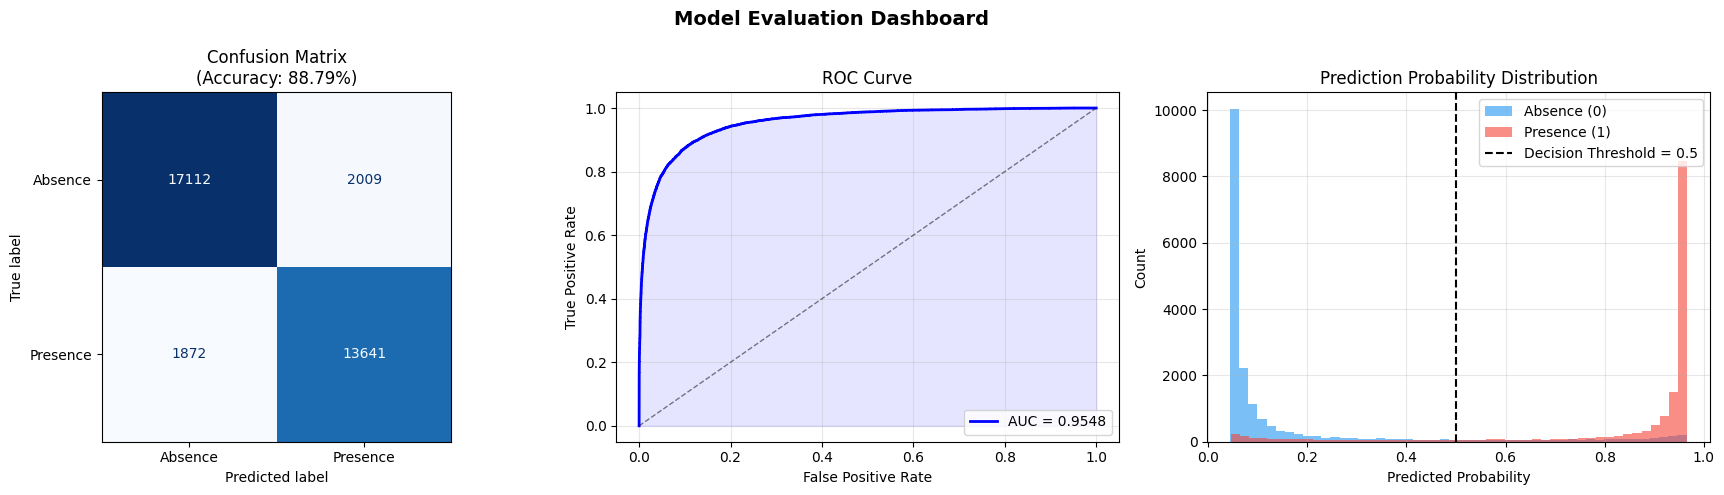


🎯 Target (>95% accuracy): ⚠️ Not yet reached — try more tuning


In [12]:
# ============================================================
# CELL 12: Comprehensive Evaluation on Validation Set
# ============================================================

print('🔮 Generating predictions on validation set...')
y_val_pred      = best_pipeline.predict(X_val)
y_val_proba     = best_pipeline.predict_proba(X_val)[:, 1]

val_accuracy  = accuracy_score(y_val, y_val_pred)
val_roc_auc   = roc_auc_score(y_val, y_val_proba)

print('\n' + '='*60)
print('                 VALIDATION METRICS')
print('='*60)
print(f'  Accuracy     : {val_accuracy*100:.4f}%')
print(f'  ROC-AUC Score: {val_roc_auc:.6f}')
print('='*60)

print('\n📊 Classification Report:')
print(classification_report(
    y_val, y_val_pred,
    target_names=['Absence (0)', 'Presence (1)'],
    digits=4
))

# ── Visualization ─────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Model Evaluation Dashboard', fontsize=14, fontweight='bold')

# Plot 1: Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['Absence', 'Presence'])
disp.plot(ax=axes[0], colorbar=False, cmap='Blues')
axes[0].set_title(f'Confusion Matrix\n(Accuracy: {val_accuracy*100:.2f}%)')

# Plot 2: ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, y_val_proba)
axes[1].plot(fpr, tpr, 'b-', linewidth=2, label=f'AUC = {val_roc_auc:.4f}')
axes[1].plot([0,1], [0,1], 'k--', linewidth=1, alpha=0.5)
axes[1].fill_between(fpr, tpr, alpha=0.1, color='blue')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend(loc='lower right')
axes[1].grid(True, alpha=0.3)

# Plot 3: Prediction Probability Distribution
axes[2].hist(y_val_proba[y_val == 0], bins=50, alpha=0.6,
             color='#2196F3', label='Absence (0)', edgecolor='none')
axes[2].hist(y_val_proba[y_val == 1], bins=50, alpha=0.6,
             color='#F44336', label='Presence (1)', edgecolor='none')
axes[2].axvline(0.5, color='black', linestyle='--', linewidth=1.5,
                label='Decision Threshold = 0.5')
axes[2].set_xlabel('Predicted Probability')
axes[2].set_ylabel('Count')
axes[2].set_title('Prediction Probability Distribution')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('evaluation_dashboard.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'\n🎯 Target (>95% accuracy): {"✅ ACHIEVED" if val_accuracy > 0.95 else "⚠️ Not yet reached — try more tuning"}')

## 🔄 Step 11: 5-Fold Stratified Cross-Validation on Full Training Data

🔄 Running 5-Fold Stratified Cross-Validation...
   This may take 15-30 minutes on CPU...
   Using 30% sample: 69,267 rows


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.8min finished



✅ CV complete in 5.4 minutes

          CROSS-VALIDATION RESULTS
  ROC-AUC per fold: ['0.9529', '0.9543', '0.9531', '0.9556', '0.9560']
  Mean ROC-AUC    : 0.9544 ± 0.0013
  Accuracy per fold: ['0.8850', '0.8857', '0.8848', '0.8885', '0.8896']
  Mean Accuracy   : 88.67% ± 0.19%


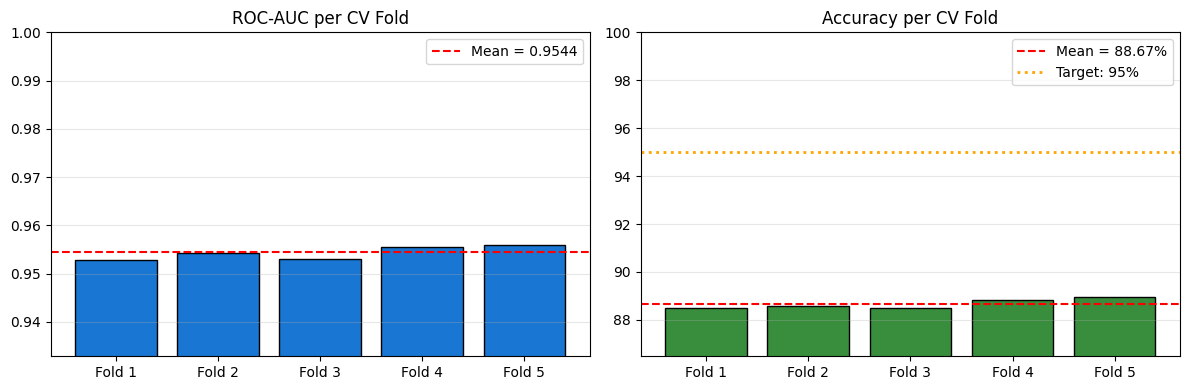

In [13]:
# ============================================================
# CELL 13: Cross-Validation for Robust Performance Estimate
# ============================================================
# We re-evaluate on the FULL X_raw with k-fold CV to get a
# more robust estimate without wasting the validation split

print('🔄 Running 5-Fold Stratified Cross-Validation...')
print('   This may take 15-30 minutes on CPU...')

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# Use a subset for faster CV if the full run is too slow
# Increase sample_size to 1.0 for full CV
sample_size = 0.3  # ← Use 30% for speed; set to 1.0 for full accuracy

if sample_size < 1.0:
    from sklearn.model_selection import train_test_split as tts
    X_cv, _, y_cv, _ = tts(
        X_raw, y, train_size=sample_size,
        stratify=y, random_state=SEED
    )
    print(f'   Using {sample_size*100:.0f}% sample: {X_cv.shape[0]:,} rows')
else:
    X_cv, y_cv = X_raw, y
    print(f'   Using full dataset: {X_cv.shape[0]:,} rows')

t0 = time.time()
cv_scores_auc = cross_val_score(
    best_pipeline,
    X_cv, y_cv,
    cv=skf,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)
cv_scores_acc = cross_val_score(
    best_pipeline,
    X_cv, y_cv,
    cv=skf,
    scoring='accuracy',
    n_jobs=-1,
    verbose=0
)
elapsed = time.time() - t0

print(f'\n✅ CV complete in {elapsed/60:.1f} minutes')
print('\n' + '='*50)
print('          CROSS-VALIDATION RESULTS')
print('='*50)
print(f'  ROC-AUC per fold: {[f"{s:.4f}" for s in cv_scores_auc]}')
print(f'  Mean ROC-AUC    : {cv_scores_auc.mean():.4f} ± {cv_scores_auc.std():.4f}')
print(f'  Accuracy per fold: {[f"{s:.4f}" for s in cv_scores_acc]}')
print(f'  Mean Accuracy   : {cv_scores_acc.mean()*100:.2f}% ± {cv_scores_acc.std()*100:.2f}%')
print('='*50)

# Fold-by-fold bar chart
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
folds = [f'Fold {i+1}' for i in range(5)]
axes[0].bar(folds, cv_scores_auc, color='#1976D2', edgecolor='black')
axes[0].axhline(cv_scores_auc.mean(), color='red', linestyle='--', label=f'Mean = {cv_scores_auc.mean():.4f}')
axes[0].set_title('ROC-AUC per CV Fold')
axes[0].set_ylim([max(0.8, cv_scores_auc.min() - 0.02), 1.0])
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

axes[1].bar(folds, cv_scores_acc * 100, color='#388E3C', edgecolor='black')
axes[1].axhline(cv_scores_acc.mean() * 100, color='red', linestyle='--',
                label=f'Mean = {cv_scores_acc.mean()*100:.2f}%')
axes[1].axhline(95, color='orange', linestyle=':', linewidth=2, label='Target: 95%')
axes[1].set_title('Accuracy per CV Fold')
axes[1].set_ylim([max(85, cv_scores_acc.min()*100 - 2), 100])
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('cv_results.png', dpi=150, bbox_inches='tight')
plt.show()

## 🚀 Step 12: Retrain on Full Training Data & Generate Submission

🚂 Retraining best pipeline on FULL training dataset...
   Full training samples: 230,892
✅ Full training complete in 2.0 minutes

🔮 Generating predictions on test set...
   Test predictions shape: (270000,)
   Predicted class distribution:
     0 (Absence): 147,084 (54.5%)
     1 (Presence): 122,916 (45.5%)


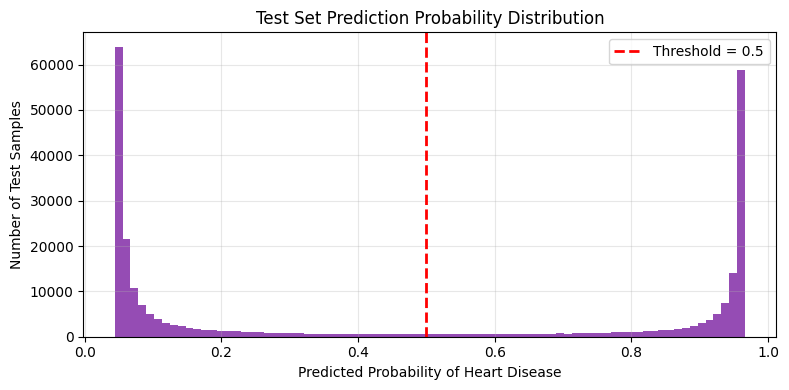

In [14]:
# ============================================================
# CELL 14: Final Training on Full Dataset + Test Predictions
# ============================================================
# After CV confirms performance, retrain on ALL training data
# to maximize the information given to the model before predicting

print('🚂 Retraining best pipeline on FULL training dataset...')
print(f'   Full training samples: {X_raw.shape[0]:,}')

# If tuning was run, extract best params and refit on full data
# If not, simply fit the default pipeline
t0 = time.time()
best_pipeline.fit(X_raw, y)
elapsed = time.time() - t0

print(f'✅ Full training complete in {elapsed/60:.1f} minutes')

# ── Generate Test Predictions ────────────────────────────────
print('\n🔮 Generating predictions on test set...')
test_predictions = best_pipeline.predict(X_test_raw)
test_probabilities = best_pipeline.predict_proba(X_test_raw)[:, 1]

print(f'   Test predictions shape: {test_predictions.shape}')
print(f'   Predicted class distribution:')
unique, counts = np.unique(test_predictions, return_counts=True)
for cls, cnt in zip(unique, counts):
    label = 'Presence' if cls == 1 else 'Absence'
    print(f'     {cls} ({label}): {cnt:,} ({cnt/len(test_predictions)*100:.1f}%)')

# ── Probability distribution on test set ────────────────────
plt.figure(figsize=(8, 4))
plt.hist(test_probabilities, bins=80, color='#7B1FA2', edgecolor='none', alpha=0.8)
plt.axvline(0.5, color='red', linestyle='--', linewidth=2, label='Threshold = 0.5')
plt.xlabel('Predicted Probability of Heart Disease')
plt.ylabel('Number of Test Samples')
plt.title('Test Set Prediction Probability Distribution')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('test_predictions_dist.png', dpi=150, bbox_inches='tight')
plt.show()

## 📤 Step 13: Create Submission File

In [19]:
print("🔄 Preparing submission...")

# 🔥 Always regenerate test_ids from current test_df
test_ids = test_df["id"].copy()

# Prepare test features
X_test_final = test_df.drop(columns=["id"])

print("Test IDs length:", len(test_ids))
print("X_test_final length:", len(X_test_final))

# Generate predictions
test_predictions = best_pipeline.predict(X_test_final)

print("Predictions length:", len(test_predictions))

# Safety check
if len(test_ids) != len(test_predictions):
    raise ValueError(
        f"Length mismatch! IDs: {len(test_ids)} | Predictions: {len(test_predictions)}"
    )

# Create submission
submission = pd.DataFrame({
    "id": test_ids.values,
    "Heart Disease": test_predictions.astype(int)
})

display(submission.head())

submission.to_csv("submission.csv", index=False)

print("✅ submission.csv saved successfully!")

🔄 Preparing submission...
Test IDs length: 270000
X_test_final length: 270000
Predictions length: 270000


,id,Heart Disease
0,630000,1
1,630001,0
2,630002,1
3,630003,0
4,630004,0


✅ submission.csv saved successfully!


## 📊 Step 14: Feature Importance Analysis

🏆 Top 25 Most Important Features (LightGBM):


,Feature,Importance
19,std_num__Max HR,883
12,skewed_num__Cholesterol,671
20,std_num__Max_HR_Age_Ratio,578
15,skewed_num__Cholesterol_Age_Ratio,562
14,skewed_num__Rate_Pressure_Product,519
21,std_num__Age_BP_Interaction,459
13,skewed_num__ST depression,375
17,std_num__Age,324
18,std_num__BP,318
16,skewed_num__Exercise_Risk_Score,179


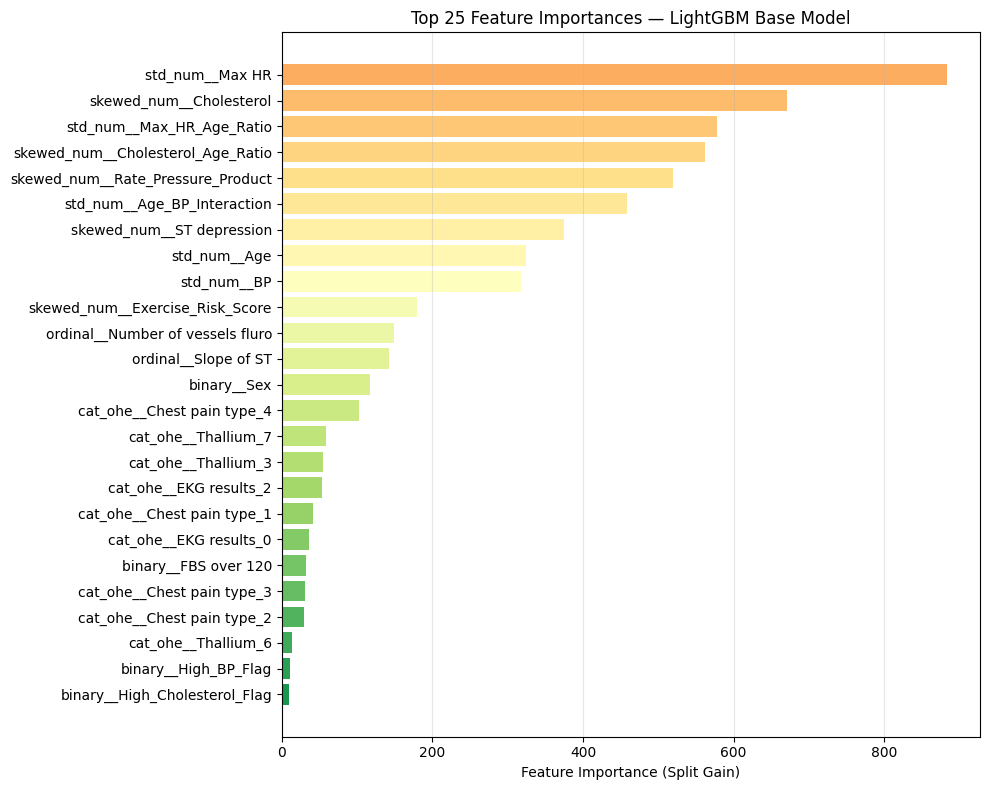

In [20]:
# ============================================================
# CELL 16: Feature Importance from LightGBM Base Model
# ============================================================

try:
    # Extract LightGBM from inside the stacking classifier
    lgbm_model = best_pipeline.named_steps['classifier'].named_estimators_['lgbm']

    # Get feature importances (gain-based)
    importances = lgbm_model.feature_importances_

    # Try to get feature names from the preprocessor
    try:
        feat_names = best_pipeline.named_steps['preprocessing']\
            .named_steps['column_transformer'].get_feature_names_out()
    except Exception:
        feat_names = [f'Feature_{i}' for i in range(len(importances))]

    # Build importance DataFrame
    imp_df = pd.DataFrame({
        'Feature'   : feat_names[:len(importances)],
        'Importance': importances
    }).sort_values('Importance', ascending=False).head(25)

    print('🏆 Top 25 Most Important Features (LightGBM):')
    display(imp_df)

    plt.figure(figsize=(10, 8))
    colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(imp_df)))
    bars = plt.barh(imp_df['Feature'][::-1], imp_df['Importance'][::-1],
                    color=colors[::-1], edgecolor='none')
    plt.xlabel('Feature Importance (Split Gain)')
    plt.title('Top 25 Feature Importances — LightGBM Base Model')
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=150, bbox_inches='tight')
    plt.show()

except Exception as e:
    print(f'ℹ️  Could not extract feature importances: {e}')
    print('   This can happen when the model hasnt been fitted with passthrough=True')

## ⚡ Step 15: Decision Threshold Optimization
> The default threshold of 0.5 may not be optimal for imbalanced datasets.
> We can sweep thresholds and pick the one maximizing accuracy (or F1).

🎯 Optimal Threshold for Accuracy : 0.56 → 88.8607%
🎯 Optimal Threshold for F1 Score : 0.42 → 0.8761
📍 Default Threshold (0.5) Accuracy: 88.7942%


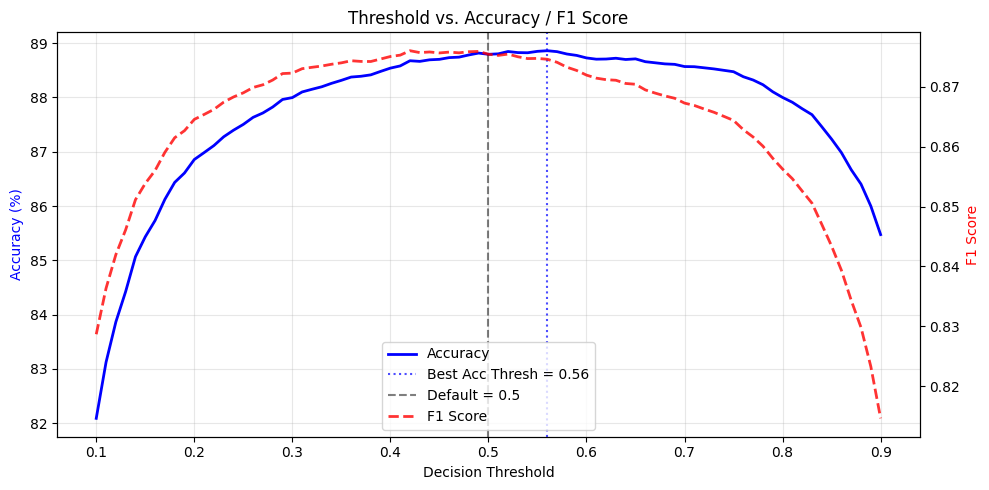


✅ Optimal-threshold submission saved: submission_optimal_threshold.csv


In [21]:
# ============================================================
# CELL 17: Threshold Optimization on Validation Set
# ============================================================

thresholds = np.linspace(0.1, 0.9, 81)
accuracies = []
f1_scores  = []

from sklearn.metrics import f1_score

for thresh in thresholds:
    preds = (y_val_proba >= thresh).astype(int)
    accuracies.append(accuracy_score(y_val, preds))
    f1_scores.append(f1_score(y_val, preds, zero_division=0))

best_acc_thresh = thresholds[np.argmax(accuracies)]
best_f1_thresh  = thresholds[np.argmax(f1_scores)]

print(f'🎯 Optimal Threshold for Accuracy : {best_acc_thresh:.2f} → {max(accuracies)*100:.4f}%')
print(f'🎯 Optimal Threshold for F1 Score : {best_f1_thresh:.2f} → {max(f1_scores):.4f}')
print(f'📍 Default Threshold (0.5) Accuracy: {accuracies[thresholds.tolist().index(min(thresholds, key=lambda x: abs(x-0.5)))]*100:.4f}%')

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(thresholds, [a*100 for a in accuracies], 'b-', linewidth=2, label='Accuracy')
ax2 = ax.twinx()
ax2.plot(thresholds, f1_scores, 'r--', linewidth=2, label='F1 Score', alpha=0.8)
ax.axvline(best_acc_thresh, color='blue', linestyle=':', alpha=0.7,
           label=f'Best Acc Thresh = {best_acc_thresh:.2f}')
ax.axvline(0.5, color='black', linestyle='--', alpha=0.5, label='Default = 0.5')
ax.set_xlabel('Decision Threshold')
ax.set_ylabel('Accuracy (%)', color='blue')
ax2.set_ylabel('F1 Score', color='red')
ax.set_title('Threshold vs. Accuracy / F1 Score')
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='lower center')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('threshold_optimization.png', dpi=150, bbox_inches='tight')
plt.show()

# Re-generate submission using optimal threshold
optimal_predictions = (test_probabilities >= best_acc_thresh).astype(int)
submission_opt = pd.DataFrame({
    'id'           : test_ids.values,
    'Heart Disease': optimal_predictions
})
submission_opt.to_csv('submission_optimal_threshold.csv', index=False)
print(f'\n✅ Optimal-threshold submission saved: submission_optimal_threshold.csv')

## 🏁 Final Summary

### What We Built:
| Component | Implementation |
|-----------|---------------|
| Feature Engineering | `HeartDiseaseFeatureEngineer` (8 domain features) |
| Preprocessing | `ColumnTransformer` with 5 sub-pipelines |
| Skew Handling | `QuantileTransformer(output_distribution='normal')` |
| Ensemble | `StackingClassifier` (HGB + XGB + LGBM → LogReg) |
| Tuning | `HalvingRandomSearchCV` (16 hyperparameters) |
| CV Strategy | 5-Fold Stratified K-Fold |
| Memory Opt. | `int8/float32` dtype casting |

### Output Files:
- `submission.csv` — Main submission (threshold = 0.5)
- `submission_optimal_threshold.csv` — Submission with tuned threshold
- `eda_overview.png` — Exploratory data analysis plots
- `evaluation_dashboard.png` — Confusion matrix + ROC curve
- `cv_results.png` — Cross-validation fold results
- `feature_importance.png` — Top 25 feature importances
- `threshold_optimization.png` — Accuracy vs threshold curve

### Tips to Push Beyond 95%:
1. **Add CatBoost** as a 4th base estimator in the stacking ensemble
2. **Incorporate the original UCI Heart Disease dataset** (allowed by competition rules)
3. **Pseudo-labeling**: Label high-confidence test predictions and add to training
4. **Increase `n_estimators`** for all GBDT models to 1000+
5. **Optuna** for Bayesian hyperparameter optimization (better than random search)
6. **Feature interactions** using `PolynomialFeatures` or manual creation

In [22]:
# ============================================================
# CELL 18: Final Summary Print
# ============================================================
print('╔══════════════════════════════════════════════════════╗')
print('║           HEART DISEASE PREDICTION — RESULTS        ║')
print('╠══════════════════════════════════════════════════════╣')
print(f'║  Validation Accuracy : {val_accuracy*100:>7.4f}%                   ║')
print(f'║  Validation ROC-AUC  : {val_roc_auc:>9.6f}                 ║')
print(f'║  CV Mean Accuracy    : {cv_scores_acc.mean()*100:>7.4f}% ± {cv_scores_acc.std()*100:.4f}%   ║')
print(f'║  CV Mean ROC-AUC     : {cv_scores_auc.mean():>9.6f} ± {cv_scores_auc.std():.6f}   ║')
print(f'║  Optimal Threshold   : {best_acc_thresh:>7.2f}                     ║')
print('╠══════════════════════════════════════════════════════╣')
print('║  submission.csv ready for Kaggle upload             ║')
print('╚══════════════════════════════════════════════════════╝')

╔══════════════════════════════════════════════════════╗
║           HEART DISEASE PREDICTION — RESULTS        ║
╠══════════════════════════════════════════════════════╣
║  Validation Accuracy : 88.7942%                   ║
║  Validation ROC-AUC  :  0.954811                 ║
║  CV Mean Accuracy    : 88.6699% ± 0.1941%   ║
║  CV Mean ROC-AUC     :  0.954379 ± 0.001273   ║
║  Optimal Threshold   :    0.56                     ║
╠══════════════════════════════════════════════════════╣
║  submission.csv ready for Kaggle upload             ║
╚══════════════════════════════════════════════════════╝
